In [ ]:
import requests
import pandas as pd
import time
from datetime import date, timedelta

In [ ]:
!pip install --upgrade bottleneck

In [ ]:
#Get game schedule
def get_all_game_ids(season_start_date, season_end_date):
    start_date = date.fromisoformat(season_start_date)
    end_date = date.fromisoformat(season_end_date)
    delta = timedelta(days=1)
    game_ids = set()

    #print(f"Fetching game IDs from {start_date} to {end_date}...")

    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime('%Y-%m-%d')
        schedule_url = f"https://api-web.nhle.com/v1/schedule/{date_str}"

        try:
            print(f"Fetching schedule for: {schedule_url}")
            response = requests.get(schedule_url)
            response.raise_for_status()
            data = response.json()

            for week in data.get('gameWeek', []):
                for game in week.get('games', []):
                    game_type = game.get('gameType')

                    if game_type in [1, 2, 3]:
                        game_ids.add(game['id'])
        except requests.exceptions.RequestException as e:
            print(f"Error fetching schedule for {date_str}: {e}")
            pass

        current_date += delta
        time.sleep(0.5)

    game_ids = list(game_ids)
    print(f"Found {len(game_ids)} games for the season.")
    return game_ids

In [ ]:
#Test get game schedule
start = '2023-10-10'
end = '2023-12-18'
game_ids = get_all_game_ids(start,end)

In [ ]:
#Get Boxsocre Info
import json
import requests

def get_game_data(game_id):
    boxscore_url = f"https://api-web.nhle.com/v1/gamecenter/{game_id}/boxscore"

    try:
        response = requests.get(boxscore_url)
        response.raise_for_status()
        data = response.json()

        home_team_data = data.get('homeTeam', {})
        away_team_data = data.get('awayTeam', {})

        return{
            'home_team_abbrev': home_team_data.get('abbrev'),
            'away_team_abbrev': away_team_data.get('abbrev'),
            'home_team_id': home_team_data.get('id'),
            'away_team_id': away_team_data.get('id')
        }

    except requests.exceptions.RequestException as e:
        print(f"Error fetcing boxscore data for game {game_id}: {e}")
        return None

In [ ]:
game_id = '2022020217'
game_data = get_game_data(game_id)
game_data

In [ ]:
pip install nhl-api-py

In [ ]:
#Get Play-by-Play data for each shot on goal
import json

def get_shot_data_for_game(game_id):
    play_by_play_url = f"https://api-web.nhle.com/v1/gamecenter/{game_id}/play-by-play"
    print(f"Fetching data from URL: {play_by_play_url}")

    team_data = get_game_data(game_id)
    if not team_data:
        print("Could not get team data.")
        return []

    home_team_abbrev = team_data.get('home_team_abbrev')
    away_team_abbrev = team_data.get('away_team_abbrev')
    home_team_id = team_data.get('home_team_id')
    away_team_id = team_data.get('away_team_id')
    #print(f"Home Team: {home_team_abbrev}, Away Team: {away_team_abbrev}")

    try:
        response = requests.get(play_by_play_url)
        response.raise_for_status()
        data = response.json()

        #print(f"API repsonse for {game_id}")
        #print(json.dumps(data, indent=2))
        #print("-" * 50)

        plays = data.get('plays', [])

        #print(f"  - API returned {len(plays)} plays for game {game_id}.")
        if not plays:
            print(f" No plays found.")
            return []

        #print(f"Found {len(plays)} plays. Processing.")

        shot_data = []
        valid_event_types = ['shot', 'goal', 'missed-shot', 'blocked-shot', 'shot-on-goal']

        for play in plays:
            event_type = play.get('typeDescKey')

            if event_type in valid_event_types:
                #print(f"Found event '{event_type}'. Checking for coordinates...")

                details = play.get('details', {})
                x_coord = details.get('xCoord')
                y_coord = details.get('yCoord')


            if event_type in valid_event_types and x_coord is not None and y_coord is not None:
                #print(f"Found an event type: {event_type}")
                event_name = play.get('typeDescKey')


                is_goal = (event_type == 'goal')
                is_home_goal = False
                is_away_goal = False
                shooting_team_abbrev = None

                event_owner_team_id = details.get('eventOwnerTeamId')
                #print(f"event id: {event_owner_team_id}, home_id: {home_team_id}, away_id: {away_team_id}.")
                if event_owner_team_id == home_team_id:
                    shooting_team_abbrev = home_team_abbrev
                    if is_goal:
                        is_home_goal = True
                else:
                    shooting_team_abbrev = away_team_abbrev
                    if is_goal:
                        is_away_goal = True

                shot_info = {
                    'game_id': game_id,
                    'home_team': home_team_abbrev,
                    'away_team': away_team_abbrev,
                    'shooting_team': shooting_team_abbrev,
                    'is_home_goal': is_home_goal,
                    'is_away_goal': is_away_goal,
                    'period': play.get('periodDescriptor', {}).get('number'),
                    'period_time_remaining': play.get('timeRemaining'),
                    'x_coord': x_coord,
                    'y_coord': y_coord,
                    'shot_type': details.get('shotType'),
                    'shooter_player_id': details.get('shootingPlayerId') or details.get('scoringPlayerId'),
                    'assist_player_id': details.get('assist1PlayerId'),
                    'is_goal': is_goal
                }

                shot_data.append(shot_info)
                #print("Shot Info: ")
                #print(json.dumps(shot_info, indent=2))

        #print(f"  - Found {len(shot_data)} shots/goals for game {game_id}.")
        return shot_data

    except requests.exceptions.RequestException as e:
        print(f"Error fetching play-by-play data for game {game_id}: {e}")
        return []


In [ ]:
#Test play-by-play data - Figure out why no shot data is returned
game_id = '2022020217'
game_data = get_shot_data_for_game(game_id)

In [ ]:
#Calculate distance and angle to goal of shot
def calculate_distance_angle(row):
    x_coord = row['x_coord']
    y_coord = row['y_coord']

    if pd.isna(x_coord) or pd.isna(y_coord):
        return np.nan, np.nan

    if x_coord < 0:
        x_coord = -x_coord

    distance = ((89 - x_coord)**2 + y_coord**2)**0.5
    angle = np.degrees(np.arctan(abs(y_coord) / abs(89 - x_coord))) if x_coord != 89 else 90

    return distance, angle

In [ ]:
# A list of the seasons you want to collect
seasons_to_collect = [
    {'season_id': '20242025', 'start_date': '2024-10-04', 'end_date': '2025-04-17'},
    {'season_id': '20232024', 'start_date': '2023-10-10', 'end_date': '2024-04-18'},
    {'season_id': '20222023', 'start_date': '2022-10-07', 'end_date': '2023-04-14'},
    {'season_id': '20212022', 'start_date': '2021-10-12', 'end_date': '2022-04-29'},
    {'season_id': '20202021', 'start_date': '2021-01-13', 'end_date': '2021-05-19'},
    {'season_id': '20192020', 'start_date': '2019-10-02', 'end_date': '2020-09-28'}
]

In [ ]:
#Build dataset
import numpy as np

for season in seasons_to_collect:
    season_id = season['season_id']
    start_date = season['start_date']
    end_date = season['end_date']
    print(f"Starting data collection for season {season_id}")

    game_ids = get_all_game_ids(start_date, end_date)
    all_shots = []

    for i, game_id in enumerate(game_ids):
        print(f"Processing game {i + 1}/{len(game_ids)}: Game ID {game_id}")
        game_shots = get_shot_data_for_game(game_id)
        all_shots.extend(game_shots)
        time.sleep(1.5)

    if all_shots:
        nhl_shots_df = pd.DataFrame(all_shots)
        #Create dataframe
        nhl_shots_df[['distance_to_goal', 'angle_to_goal']] = nhl_shots_df.apply(
        lambda row: pd.Series(calculate_distance_angle(row)), axis=1)

        output_filename = f"nhl_shot_data_{season_id}.csv"
        nhl_shots_df.to_csv(output_filename, index=False)

        print(f"\nData collection completed and saved!")
        print(nhl_shots_df.head())
    else:
        print(f"No data found for season {season_id}.")

Starting data collection for season 20222023
Fetching schedule for: https://api-web.nhle.com/v1/schedule/2022-10-07
Fetching schedule for: https://api-web.nhle.com/v1/schedule/2022-10-08
Fetching schedule for: https://api-web.nhle.com/v1/schedule/2022-10-09
Fetching schedule for: https://api-web.nhle.com/v1/schedule/2022-10-10
Fetching schedule for: https://api-web.nhle.com/v1/schedule/2022-10-11
Fetching schedule for: https://api-web.nhle.com/v1/schedule/2022-10-12
Fetching schedule for: https://api-web.nhle.com/v1/schedule/2022-10-13
Fetching schedule for: https://api-web.nhle.com/v1/schedule/2022-10-14
Fetching schedule for: https://api-web.nhle.com/v1/schedule/2022-10-15
Fetching schedule for: https://api-web.nhle.com/v1/schedule/2022-10-16
Fetching schedule for: https://api-web.nhle.com/v1/schedule/2022-10-17
Fetching schedule for: https://api-web.nhle.com/v1/schedule/2022-10-18
Fetching schedule for: https://api-web.nhle.com/v1/schedule/2022-10-19
Fetching schedule for: https://a

In [ ]:
import pandas as pd
import os
import requests
import time

def get_player_name(player_id, cache):

    if not player_id:
        return None
    if player_id in cache:
        return cache[player_id]

    try:
        player_url = f"https://api-web.nhle.com/v1/player/{player_id}/landing"
        response = requests.get(player_url)
        response.raise_for_status()
        data = response.json()

        full_name = data.get('fullName', {}).get('default')
        if not full_name:
            full_name = data.get('firstName', {}).get('default') + ' ' + data.get('lastName', {}).get('default')

        if full_name and full_name.strip():
            cache[player_id] = full_name
            print(f"  - Found name for ID {player_id}: {full_name}")
            return full_name

        print(f"  - WARNING: Player data for ID {player_id} does not contain a name.")
        return None
    except requests.exceptions.RequestException as e:
        print(f"Error fetching player data for ID {player_id}: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred for player ID {player_id}: {e}")
        return None


output_file = 'nhl_shot_data_with_names.csv'

seasons_to_collect = [
    {'season_id': '20242025', 'start_date': '2024-10-04', 'end_date': '2025-04-17'},
    {'season_id': '20232024', 'start_date': '2023-10-10', 'end_date': '2024-04-18'},
    {'season_id': '20222023', 'start_date': '2022-10-07', 'end_date': '2023-04-14'},
    {'season_id': '20212022', 'start_date': '2021-10-12', 'end_date': '2022-04-29'},
    {'season_id': '20202021', 'start_date': '2021-01-13', 'end_date': '2021-05-19'},
    {'season_id': '20192020', 'start_date': '2019-10-02', 'end_date': '2020-09-28'}
]


all_player_ids = set()
print("Collecting unique player IDs from all CSV files...")
for season in seasons_to_collect:
    season_file = f"nhl_shot_data_{season['season_id']}.csv"
    if os.path.exists(season_file):
        try:
            df = pd.read_csv(season_file)
            if 'shooter_player_id' in df.columns:
                all_player_ids.update(df['shooter_player_id'].dropna().astype(int).unique())
            if 'assist_player_id' in df.columns:
                all_player_ids.update(df['assist_player_id'].dropna().astype(int).unique())
        except Exception as e:
            print(f"An error occurred while reading {season_file}: {e}")

print(f"Found {len(all_player_ids)} unique player IDs.")


master_player_map = {}
fetched_count = 0
total_ids = len(all_player_ids)
print(f"Starting to fetch names for all {total_ids} players...")
for player_id in all_player_ids:
    get_player_name(player_id, master_player_map)

    fetched_count += 1
    if fetched_count % 100 == 0:
        print(f"  - Fetched data for {fetched_count}/{total_ids} players...")
    time.sleep(0.05)

print(f"Finished fetching all player data. Found {len(master_player_map)} names successfully.")

if not master_player_map:
    print("Cannot proceed without a master player map. Exiting.")
else:
    all_dataframes = []
    for season in seasons_to_collect:
        season_id = season['season_id']
        season_file = f"nhl_shot_data_{season_id}.csv"

        if not os.path.exists(season_file):
            print(f"Skipping season {season_id}: File '{season_file}' not found.")
            continue

        try:
            nhl_shots_df = pd.read_csv(season_file)

            nhl_shots_df['shooter_name'] = nhl_shots_df['shooter_player_id'].map(master_player_map)
            nhl_shots_df['assist_name'] = nhl_shots_df['assist_player_id'].map(master_player_map)

            all_dataframes.append(nhl_shots_df)
            print(f"Successfully processed data for season {season_id}.")

        except Exception as e:
            print(f"An error occurred while processing {season_file}: {e}")


    if all_dataframes:
        final_df = pd.concat(all_dataframes, ignore_index=True)
        final_df.to_csv(output_file, index=False)
        print(f"\nSuccessfully combined and wrote all data to '{output_file}'.")
    else:
        print("\nNo dataframes were processed. No output file was created.")


Found 1635 unique player IDs.
Starting to fetch names for all 1635 players...
  - Found name for ID 8470594: Marc-Andre Fleury
  - Found name for ID 8470595: Eric Staal
  - Found name for ID 8470600: Ryan Suter
  - Found name for ID 8470601: Braydon Coburn
  - Found name for ID 8470604: Jeff Carter
  - Found name for ID 8470606: Dustin Brown
  - Found name for ID 8470607: Brent Seabrook
  - Found name for ID 8470610: Zach Parise
  - Found name for ID 8470612: Ryan Getzlaf
  - Found name for ID 8470613: Brent Burns
  - Found name for ID 8470619: Brian Boyle
  - Found name for ID 8470621: Corey Perry
  - Found name for ID 8470626: Loui Eriksson
  - Found name for ID 8470638: Patrice Bergeron
  - Found name for ID 8478831: Kevin Stenlund
  - Found name for ID 8478833: J.C. Beaudin
  - Found name for ID 8470642: Shea Weber
  - Found name for ID 8478838: Lukas Vejdemo
  - Found name for ID 8478839: Aleksi Saarela
  - Found name for ID 8478840: Will Borgen
  - Found name for ID 8478841: Colt

Data loaded
Training data shape: (516860, 12)
Testing data shape: (129215, 12)
Training Logistic Regression model.
Model training done.
Evaluate accuracy of model.
Model Accuracy: 0.9276
Model Log Loss: 0.2387
Generating calibration plot.


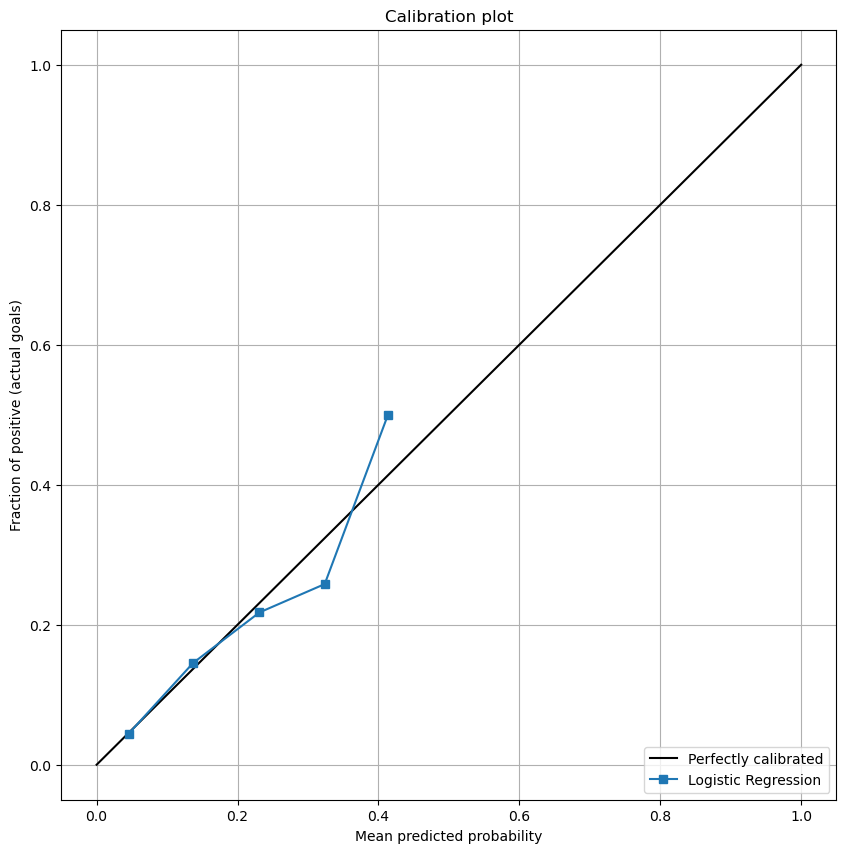

Created xG model, calculated accuracy, and calculated calibration.


In [ ]:
#Train xG Model + Evaluate Accuracy and Calibration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.calibration import calibration_curve

try:
    df = pd.read_csv('nhl_shot_data_with_names.csv')
    print("Data loaded")

except FileNotFoundError:
    print("Error: The file 'nhl_shot_data_with_names.csv' was not found.")
    exit()

df.dropna(subset=['shooter_player_id', 'distance_to_goal', 'angle_to_goal', 'shot_type'], inplace=True)
df['shot_type'] = df['shot_type'].astype('category')

numerical_features = ['distance_to_goal', 'angle_to_goal']
categorical_features = ['shot_type']

x = pd.get_dummies(df,columns=categorical_features, drop_first=True)
all_features = numerical_features + [col for col in x.columns if col.startswith('shot_type_')]
x = x[all_features]
y = df['is_goal']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Training data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")

print("Training Logistic Regression model.")
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(x_train, y_train)
print("Model training done.")

print("Evaluate accuracy of model.")
y_pred_proba = model.predict_proba(x_test)[:,1]
y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

logloss = log_loss(y_test, y_pred_proba)
print(f"Model Log Loss: {logloss:.4f}")

print("Generating calibration plot.")
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.figure(figsize=(10,10))
plt.plot([0,1], [0,1], 'k', label='Perfectly calibrated')
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Logistic Regression')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positive (actual goals)')
plt.title('Calibration plot')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print('Created xG model, calculated accuracy, and calculated calibration.')

In [4]:
# Build xG vs Goal Dashboard
# Run cell to view dashboard

!pip install dash jupyter-dash

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from jupyter_dash import JupyterDash
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


GOOGLE_DRIVE_FILE_ID = '1dCdaf1ftuzoDbkAut8ESmdE6htK8AlKA'

DIRECT_DOWNLOAD_URL = f'https://drive.google.com/uc?id={'1dCdaf1ftuzoDbkAut8ESmdE6htK8AlKA'}&export=download'

try:
    print("Attempting to load data from Google Drive...")
    df = pd.read_csv(DIRECT_DOWNLOAD_URL)
    print("Data loaded successfully from Google Drive.")
except Exception as e:
    print(f"Error loading data from Google Drive: {e}")
    print("Please ensure the GOOGLE_DRIVE_FILE_ID is correct and the file is publicly shared.")
    exit()

# ==============================================================================
# 2. DATA CLEANING AND MODEL TRAINING
# ==============================================================================

df.dropna(subset=['shooter_player_id', 'distance_to_goal', 'angle_to_goal', 'shot_type', 'is_goal', 'x_coord', 'y_coord'], inplace=True)
df['shot_type'] = df['shot_type'].astype('category')

numerical_features = ['distance_to_goal', 'angle_to_goal']
categorical_features = ['shot_type']

X = pd.get_dummies(df[numerical_features + categorical_features], columns=categorical_features, drop_first=True)
y = df['is_goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training the Logistic Regression model...")
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)
print("Model training complete.")


X_full = pd.get_dummies(df[numerical_features + categorical_features], columns=categorical_features, drop_first=True)


missing_cols = set(X_train.columns) - set(X_full.columns)
for c in missing_cols:
    X_full[c] = 0
X_full = X_full[X_train.columns]


df['xG'] = model.predict_proba(X_full)[:, 1]


# ==============================================================================
# 3. DASHBOARD LAYOUT AND CALLBACKS
# ==============================================================================

app = JupyterDash(__name__)

teams = sorted(df['shooting_team'].unique())
players = sorted(df['shooter_name'].unique())
shot_types = sorted(df['shot_type'].unique())

def create_rink_layout_shapes():
    """Generates the SVG path and shape definitions for an NHL half-rink."""
    rink_shapes = [
        dict(
            type='rect',
            x0=-100, y0=-42.5, x1=100, y1=42.5,
            fillcolor='#EAF3F9',
            line_width=0,
            opacity=1.0,
            layer='below'
        ),
        # Center Line
        dict(
            type='line',
            x0=0, y0=-42.5, x1=0, y1=42.5,
            line=dict(color='red', width=3, dash='dash')
        ),
        # Blue Lines
        dict(
            type='line',
            x0=-25, y0=-42.5, x1=-25, y1=42.5,
            line=dict(color='blue', width=3)
        ),
        dict(
            type='line',
            x0=25, y0=-42.5, x1=25, y1=42.5,
            line=dict(color='blue', width=3)
        ),
        # Goal Line
        dict(
            type='line',
            x0=-89, y0=-42.5, x1=-89, y1=42.5,
            line=dict(color='red', width=3)
        ),
        # Center Circle
        dict(
            type='circle',
            xref='x', yref='y',
            x0=-15, y0=-15, x1=15, y1=15,
            line_color='blue',
            line_width=2
        ),
        # Goal posts
        dict(
            type='circle', x0=-89.5, y0=-3, x1=-88.5, y1=-3,
            line=dict(color='black', width=4), fillcolor='white'
        ),
        dict(
            type='circle', x0=-89.5, y0=3, x1=-88.5, y1=3,
            line=dict(color='black', width=4), fillcolor='white'
        ),
        # Goal Crease
        dict(
            type='path',
            path='M-87,-4 A4,4 0 0,0 -87,4 L-89,4 L-89,-4 Z',
            fillcolor='red',
            line_color='red',
            line_width=2,
            opacity=0.3
        ),
    ]
    return rink_shapes


app.layout = html.Div(
    style={'backgroundColor': '#f5f5f5', 'fontFamily': 'Inter, sans-serif', 'padding': '20px'},
    children=[
        html.H1("NHL Expected Goals (xG) vs Actual Goals Dashboard",
                style={'textAlign': 'center', 'color': '#2C3E50', 'marginBottom': '10px'}),

        html.P("Analyze shot locations, expected goals (size of marker), and actual goals (green/red color) by team, player, and shot type.",
               style={'textAlign': 'center', 'color': '#7F8C8D', 'marginBottom': '30px'}),

        html.Div([
            html.Div(
                children=[
                    html.Label("Select Team:", style={'fontWeight': 'bold', 'color': '#34495E', 'marginBottom': '5px'}),
                    dcc.Dropdown(
                        id='team-dropdown',
                        options=[{'label': i, 'value': i} for i in teams] + [{'label': 'All Teams', 'value': 'All'}],
                        value='All',
                        clearable=False,
                        style={'borderRadius': '8px', 'boxShadow': '2px 2px 5px rgba(0,0,0,0.1)'}
                    )
                ],
                style={'flexGrow': 1, 'marginRight': '20px'}
            ),
            html.Div(
                children=[
                    html.Label("Select Player:", style={'fontWeight': 'bold', 'color': '#34495E', 'marginBottom': '5px'}),
                    dcc.Dropdown(
                        id='player-dropdown',
                        options=[{'label': i, 'value': i} for i in players] + [{'label': 'All Players', 'value': 'All'}],
                        value='All',
                        clearable=False,
                        style={'borderRadius': '8px', 'boxShadow': '2px 2px 5px rgba(0,0,0,0.1)'}
                    )
                ],
                style={'flexGrow': 1, 'marginRight': '20px'}
            ),
            html.Div(
                children=[
                    html.Label("Select Shot Type:", style={'fontWeight': 'bold', 'color': '#34495E', 'marginBottom': '5px'}),
                    dcc.Dropdown(
                        id='shot-type-dropdown',
                        options=[{'label': i, 'value': i} for i in shot_types] + [{'label': 'All Shot Types', 'value': 'All'}],
                        value='All',
                        clearable=False,
                        style={'borderRadius': '8px', 'boxShadow': '2px 2px 5px rgba(0,0,0,0.1)'}
                    )
                ],
                style={'flexGrow': 1}
            ),
        ], style={'display': 'flex', 'justifyContent': 'space-around', 'padding': '10px', 'backgroundColor': 'white', 'borderRadius': '12px', 'boxShadow': '0 4px 8px rgba(0,0,0,0.05)', 'marginBottom': '20px'}),

        dcc.Graph(id='shot-map-graph', style={'height': '80vh', 'borderRadius': '12px', 'overflow': 'hidden', 'boxShadow': '0 4px 8px rgba(0,0,0,0.1)'})
    ]
)


@app.callback(
    Output('shot-map-graph', 'figure'),
    [Input('team-dropdown', 'value'),
     Input('player-dropdown', 'value'),
     Input('shot-type-dropdown', 'value')]
)
def update_graph(selected_team, selected_player, selected_shot_type):
    """Filters data based on dropdown selections and updates the shot map."""

    filtered_df = df.copy()

    # Apply filters
    if selected_team != 'All':
        filtered_df = filtered_df[filtered_df['shooting_team'] == selected_team]

    if selected_player != 'All':
        filtered_df = filtered_df[filtered_df['shooter_name'] == selected_player]

    if selected_shot_type != 'All':
        filtered_df = filtered_df[filtered_df['shot_type'] == selected_shot_type]

    # Calculate Totals for Title
    total_shots = len(filtered_df)
    total_goals = filtered_df['is_goal'].sum()
    total_xg = filtered_df['xG'].sum()

    title_text = f"Shot Map | Shots: {total_shots} | Goals: {total_goals} | Total xG: {total_xg:.2f}"

    fig = go.Figure()

    # Add shot data to the plot
    if not filtered_df.empty:
        fig.add_trace(go.Scatter(
            x=filtered_df['x_coord'],
            y=filtered_df['y_coord'],
            mode='markers',
            name='Shots',
            marker=dict(
                symbol='circle',
                size=filtered_df['xG'] * 80 + 5,
                color=['#2ECC71' if is_goal else '#E74C3C' for is_goal in filtered_df['is_goal']],
                opacity=0.75,
                line=dict(width=1.5, color='rgba(52, 73, 94, 0.8)')
            ),
            hovertemplate="<b>%{customdata[0]}</b><br>" +
                          "Team: %{customdata[1]}<br>" +
                          "Type: %{customdata[2]}<br>" +
                          "Result: %{customdata[3]}<br>" +
                          "xG: %{customdata[4]:.3f}" +
                          "<extra></extra>",
            customdata=np.stack((
                filtered_df['shooter_name'],
                filtered_df['shooting_team'],
                filtered_df['shot_type'],
                filtered_df['is_goal'].map({1: 'Goal', 0: 'Miss'}),
                filtered_df['xG']
            ), axis=-1)
        ))

    # Update plot layout
    fig.update_layout(
        title={'text': title_text, 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
        xaxis_title='X Coordinate',
        yaxis_title='Y Coordinate',
        xaxis_range=[-100, 100],
        yaxis_range=[-45, 45],
        height=750,
        template='plotly_white',
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='white',
        shapes=create_rink_layout_shapes(),
        xaxis=dict(showgrid=False, zeroline=False, visible=False),
        yaxis=dict(showgrid=False, zeroline=False, visible=False),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    return fig

if __name__ == '__main__':
    app.run(mode='inline', port=8050)


Attempting to load data from Google Drive...
Data loaded successfully from Google Drive.
Training the Logistic Regression model...
Model training complete.


/usr/local/lib/python3.12/dist-packages/dash/dash.py:634: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



<IPython.core.display.Javascript object>